# Six Southern Labor Markets #4
### Labor force status

February 8, 2019

Brian Dew, @bd_econ

-----

Look at what share of 16-64 year old men and women are unemployed, employed, or not in the labor force, and how this compares to national average. Then compare the total change from 2015 to 2018 for each area and the US as a whole.

Areas:

- Chattanooga
- Knoxville
- Greenville
- Asheville
- Kingsport
- Huntsville
- US total

In [1]:
import pandas as pd
import numpy as np
import pickle
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [2]:
areas = [('Chattanooga-Cleveland-Dalton, TN-GA', 'CSA', [174]),
         ('Greenville-Anderson-Spartanburg, SC', 'CSA', [273]),
         ('Asheville, NC', 'CBSA', [11700]),
         ('Johnson City-Kingsport-Bristol, TN-VA', 'CSA', [304]),
         ('Huntsville, AL', 'CBSA', [26620]),
         ('Knoxville, TN', 'CBSA', [28940])]

area_names = [area[0] for area in areas]

In [3]:
csa = [area[2][0] for area in areas if area[1] == 'CSA']
cbsa = [area[2][0] for area in areas if area[1] == 'CBSA']
grps = [('US Total', 'AGE > -1')]
grps2 = [(area[0], f'{area[1]} == {area[2][0]}') for area in areas]
groups = grps2 + grps

### Labor force status

In [4]:
# CPS data
os.chdir('/home/brian/Documents/CPS/data/clean')

# Subset of columns of interest
columns = ['MONTH', 'YEAR', 'CBSA', 'CSA', 'AGE', 'STATE', 'REGION',
           'BASICWGT', 'LFS', 'FEMALE']

df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                for year in [2018]])

In [5]:
# Collect results for total, men, women in each area
results = pd.DataFrame()
for group in groups:
    data = df.query(group[1])
    data = data.query('16 <= AGE <= 64')
    i = data.groupby('LFS').BASICWGT.sum()
    s = ((i / data.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Total'
        results.at[row_name, idx] = val    
    men = data.query('FEMALE == 0')
    i = men.groupby('LFS').BASICWGT.sum()
    s = ((i / men.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Men'
        results.at[row_name, idx] = val
    women = data.query('FEMALE == 1')
    i = women.groupby('LFS').BASICWGT.sum()
    s = ((i / women.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Women'
        results.at[row_name, idx] = val
        
results1 = results[['Unemployed', 'Employed', 'NILF']]

### Clean up data and sort by employment share (total)

In [6]:
# Custom sort - most employed first, US total last
filter_list = [area for area in list(results1.index) 
               if 'US' not in area and 'Total' in area]
sorted_list = list(results1.loc[filter_list]
                           .sort_values(by='Employed')
                           .index)
sorted_names = [i.replace(', Total', '') for i in sorted_list]

m_w_list = [(i.replace('Total', 'Men'), i.replace('Total', 'Women'))
            for i in sorted_list]
temp_list = [('US Total, Men', 'US Total, Women')] + m_w_list
col_list = list(sum(temp_list, ()))

results = results1.loc[col_list]

areas = ['US Total'] + sorted_names

In [7]:
# Get start location for each bar segment
temp = results.cumsum(axis=1).iloc[:,:-1]
temp['start'] = 0
temp = temp[['start', 'Unemployed', 'Employed']]
start_locs = temp.rename({'start': 'Unemployed', 'Unemployed': 'Employed', 
                          'Employed': 'NILF'}, axis=1)

# Get length of each bar segment
len_locs = results

# Get y values for each bar (with blank space for label)
y_values = []
i = 0.0
for _ in range(7):
    y_values.extend([i, i+1])
    i = i + 2.8

# Color for each LFS group (orange, blue, green)
colors = ['#ff7f00', '#377eb8', '#4daf4a']

# Combine lfs group names with colors
lfs_groups = list(zip(colors, ['Unemployed', 'Employed', 'NILF']))

In [8]:
# Main city name labels
label_y_locs = [y + 2 for y in y_values[::2]]
area_labels = list(zip(areas, label_y_locs))

# Men/ Women labels
label_y_locs = y_values
label_text = ['M', 'F'] * 7
mw_labels = list(zip(label_y_locs, label_text))

### LFS chart

In [9]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

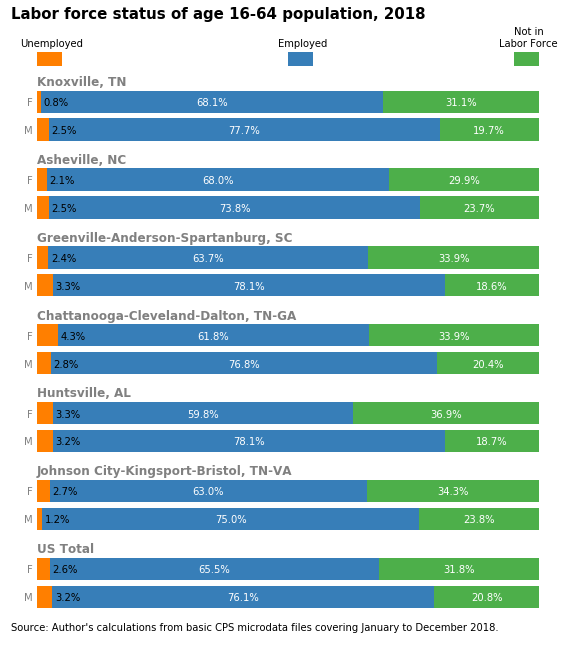

In [10]:
# Very custom stacked horizontal bar chart
fig = plt.figure(figsize=(9,11))

plt.ylim(-0.5, 21)
plt.xlim(0, 100)

ax = plt.gca()
    
for color, lfs_level in lfs_groups:
    bar_segments = []
    start_loc = start_locs[lfs_level].values
    len_loc = len_locs[lfs_level].values
    data = list(zip(start_loc, len_loc, y_values))
    for seg in data:
        rect = Rectangle((seg[0], seg[2]), seg[1], 0.8)
        bar_segments.append(rect)
        
        # Put data value text at bar midpoint
        text_x_val = (seg[1] / 2 + seg[0])
        text_color = 'white'
        if lfs_level == 'Unemployed':
            text_x_val = seg[1] + 3
            text_color = 'black'
        text_y_val = seg[2] + 0.275
        text_val = f'{round(seg[1], 1)}%'
        plt.text(text_x_val, text_y_val, text_val,
                 fontsize=10, color=text_color, ha='center')

    bars = PatchCollection(bar_segments, facecolor=color, edgecolor='none')
                        
    ax.add_collection(bars)

for name, y_loc in area_labels:
    plt.text(0, y_loc, name, fontsize=12, color='gray', weight='bold')

for y_loc, name in mw_labels:
    plt.text(-0.8, y_loc + 0.275, name, fontsize=10, color='gray', ha='right')
    
# Custom legend at top of plot
plt.text(3, 20.2, 'Unemployed', ha='center')
rect = Rectangle((0, 19.5), 5, 0.5, facecolor='#ff7f00', edgecolor='none')
ax.add_patch(rect)

plt.text(53, 20.2, 'Employed', ha='center')
rect = Rectangle((50, 19.5), 5, 0.5, facecolor='#377eb8', edgecolor='none')
ax.add_patch(rect)

plt.text(98, 20.2, 'Not in\nLabor Force', ha='center')
rect = Rectangle((95, 19.5), 5, 0.5, facecolor='#4daf4a', edgecolor='none')
ax.add_patch(rect)
    
# add title and footer
plt.text(-5, 21.2, 'Labor force status of age 16-64 population, 2018', 
          fontsize=15, weight='bold')

plt.text(-5, -0.8, "Source: Author's calculations from basic CPS microdata files covering January to December 2018.")

plt.axis('off')

plt.savefig('lfs.png', bbox_inches='tight');

### Change from 2015 to 2018

In [11]:
# CPS data
os.chdir('/home/brian/Documents/CPS/data/clean')

# Subset of columns of interest
columns = ['MONTH', 'YEAR', 'CBSA', 'CSA', 'AGE', 'STATE', 'REGION',
           'BASICWGT', 'LFS', 'FEMALE']

df = pd.concat([pd.read_feather(f'cps{year}.ft', columns=columns)
                for year in [2015]])

In [12]:
# Collect results for total, men, women in each area
results2 = pd.DataFrame()
for group in groups:
    data = df.query(group[1])
    data = data.query('16 <= AGE <= 64')
    i = data.groupby('LFS').BASICWGT.sum()
    s = ((i / data.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Total'
        results2.at[row_name, idx] = val
    men = data.query('FEMALE == 0')
    i = men.groupby('LFS').BASICWGT.sum()
    s = ((i / men.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Men'
        results2.at[row_name, idx] = val
    women = data.query('FEMALE == 1')
    i = women.groupby('LFS').BASICWGT.sum()
    s = ((i / women.BASICWGT.sum()) * 100)
    for idx, val in s.iteritems():
        row_name = f'{group[0]}, Women'
        results2.at[row_name, idx] = val
        
results2 = results2[['Unemployed', 'Employed', 'NILF']]

In [13]:
results = results1 - results2

In [14]:
# Custom sort - most advanced degrees first, US total last
filter_list = [area for area in list(results.index) 
               if 'US' not in area and 'Total' in area]
sorted_list = list(results.loc[filter_list]
                           .sort_values(by='Employed')
                           .index)
sorted_names = [i.replace(', Total', '') for i in sorted_list]

m_w_list = [(i.replace('Total', 'Men'), i.replace('Total', 'Women'))
            for i in sorted_list]
temp_list = [('US Total, Men', 'US Total, Women')] + m_w_list
col_list = list(sum(temp_list, ()))

results = results.loc[col_list]

areas = ['US Total'] + sorted_names

In [15]:
results

,Unemployed,Employed,NILF
"US Total, Men",-1.121124,1.885254,-0.764105
"US Total, Women",-0.877599,2.134121,-1.256533
"Asheville, NC, Men",-1.006476,1.588737,-0.582268
"Asheville, NC, Women",-2.715551,2.070999,0.644562
"Chattanooga-Cleveland-Dalton, TN-GA, Men",-1.691768,3.007660,-1.315895
"Chattanooga-Cleveland-Dalton, TN-GA, Women",0.621421,2.708488,-3.329914
"Greenville-Anderson-Spartanburg, SC, Men",-1.242562,6.111549,-4.868988
"Greenville-Anderson-Spartanburg, SC, Women",-1.513466,0.453438,1.060036
"Johnson City-Kingsport-Bristol, TN-VA, Men",-3.956286,5.520493,-1.564205
"Johnson City-Kingsport-Bristol, TN-VA, Women",-0.737501,4.138016,-3.400520


In [16]:
# Get start location for each bar segment 
start_locs = pd.DataFrame()
for group_name, values in results.iterrows():
    start_locs.at[group_name, 'Employed'] = 0
    if values['Unemployed'] >= 0:
        start_locs.at[group_name, 'Unemployed'] = values['Employed']
        start_locs.at[group_name, 'NILF'] = values['NILF']
    if values['Unemployed'] < 0:
        start_locs.at[group_name, 'Unemployed'] = values['Unemployed']
        if values['NILF'] < 0:
            start_locs.at[group_name, 'NILF'] = values['Unemployed'] + values['NILF']
        if values['NILF'] >= 0:
            start_locs.at[group_name, 'NILF'] = values['Employed']

# Get length of each bar segment
len_locs = abs(results)

# Get y values for each bar (with blank space for label)
y_values = []
i = 0.0
for _ in range(7):
    y_values.extend([i, i+1])
    i = i + 2.8

# Color for each LFS group (orange, blue, green)
colors = ['#ff7f00', '#377eb8', '#4daf4a']

# Combine lfs group names with colors
lfs_groups = list(zip(colors, ['Unemployed', 'Employed', 'NILF']))

In [17]:
# Main city name labels
label_y_locs = [y + 2 for y in y_values[::2]]
area_labels = list(zip(areas, label_y_locs))

# Men/ Women labels
label_y_locs = y_values
label_text = ['M', 'F'] * 7
mw_labels = list(zip(label_y_locs, label_text))

### Labor force change chart

In [18]:
os.chdir('/home/brian/Documents/blog_posts/Southern_Six/')

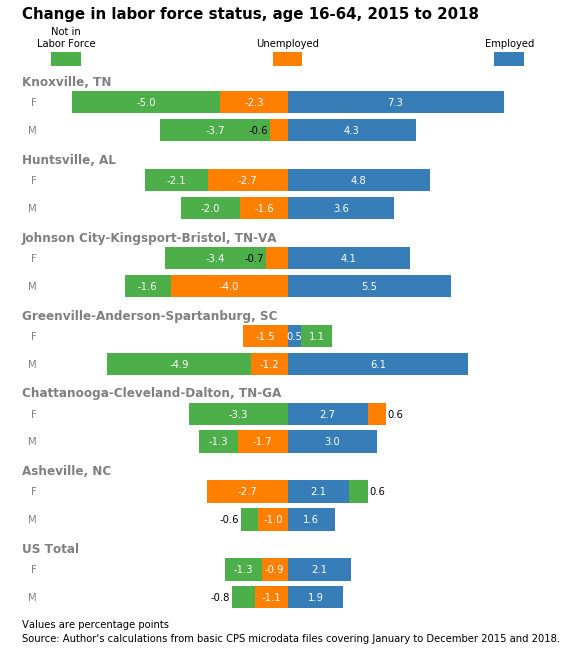

In [19]:
# Very custom stacked horizontal bar chart
fig = plt.figure(figsize=(9,11))

plt.ylim(-0.5, 21)
plt.xlim(-8.5, 8.5)

ax = plt.gca()
    
for color, lfs_level in lfs_groups:
    bar_segments = []
    start_loc = start_locs[lfs_level].values
    len_loc = len_locs[lfs_level].values
    data = list(zip(start_loc, len_loc, y_values))
    for seg in data:
        rect = Rectangle((seg[0], seg[2]), seg[1], 0.8)
        bar_segments.append(rect)

        # Put data value text at bar midpoint
        text_x_val = (seg[1] / 2 + seg[0])
        text_color = 'white'
        if (seg[1] < 0.85) & (seg[0] < 0):
            text_x_val = seg[0] - 0.4
            text_color = 'black'
        if (seg[1] < 0.85) & (seg[0] > 0):
            text_x_val = seg[0] + seg[1] + 0.33
            text_color = 'black'
        text_y_val = seg[2] + 0.275
        text_val = f'{round(seg[1], 1)}'
        if seg[0] < 0:
            text_val = f'{-round(seg[1], 1)}'
        plt.text(text_x_val, text_y_val, text_val,
                 fontsize=10, color=text_color, ha='center')
        
    bars = PatchCollection(bar_segments, facecolor=color, edgecolor='none')
                        
    ax.add_collection(bars)

for name, y_loc in area_labels:
    plt.text(-9, y_loc, name, fontsize=12, color='gray', weight='bold')

for y_loc, name in mw_labels:
    plt.text(-8.5, y_loc + 0.275, name, fontsize=10, color='gray', ha='right')
    
# Custom legend at top of plot
plt.text(-0, 20.2, 'Unemployed', ha='center')
rect = Rectangle((-0.5, 19.5), 1, 0.5, facecolor='#ff7f00', edgecolor='none')
ax.add_patch(rect)

plt.text(7.5, 20.2, 'Employed', ha='center')
rect = Rectangle((7, 19.5), 1, 0.5, facecolor='#377eb8', edgecolor='none')
ax.add_patch(rect)

plt.text(-7.5, 20.2, 'Not in\nLabor Force', ha='center')
rect = Rectangle((-8, 19.5), 1, 0.5, facecolor='#4daf4a', edgecolor='none')
ax.add_patch(rect)    
    
    
# add title and footer
plt.text(-9, 21.2, 'Change in labor force status, age 16-64, 2015 to 2018', 
          fontsize=15, weight='bold')
plt.text(-9, -0.7, "Values are percentage points")
plt.text(-9, -1.2, "Source: Author's calculations from basic CPS microdata files covering January to December 2015 and 2018.")

plt.axis('off')

plt.savefig('lfs_change.png', bbox_inches='tight');